In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, applications, Input, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight
from sklearn.metrics import classification_report, f1_score
import matplotlib.pyplot as plt

In [2]:
# -----------------------------
# 1. Data Loading & Preprocessing
# -----------------------------
# Load train/validation images and labels
images = np.load('data/ps4_trainvalid_images.npy')         # e.g. shape (N, H, W, 1, 1) or (N, H, W, 1)
labels_df = pd.read_csv('data/ps4_trainvalid_labels.csv')  # columns: Id, Label

# Remove any singleton dimensions and normalize
images = np.squeeze(images)                           # now (N, H, W)
images = images.astype('float32') / 255.0
images = np.expand_dims(images, axis=-1)              # now (N, H, W, 1)

# Extract labels and one-hot encode
labels = labels_df['Label'].values                    # shape (N,)
labels_cat = to_categorical(labels, num_classes=3)

# Split into train/validation (stratified)
X_train, X_val, y_train, y_val = train_test_split(
    images, labels_cat,
    test_size=0.2,
    stratify=labels,
    random_state=42
)

In [3]:
# -----------------------------
# 2. Basic CNN Definition
# -----------------------------
def build_cnn(input_shape=(64,64,1), num_classes=3):
    """Simple CNN with three conv blocks, dropout, and dense head."""
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax'),
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [4]:
# -----------------------------
# 3. Data Augmentation
# -----------------------------
# Create an ImageDataGenerator for augmentation
aug_gen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator = aug_gen.flow(X_train, y_train, batch_size=32)


In [5]:
# -----------------------------
# 4. Class Weights
# -----------------------------
# Compute balanced class weights to handle any imbalance
y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_integers),
    y=y_integers
)
class_weight_dict = dict(enumerate(class_weights))


In [6]:
# -----------------------------
# 5. Train Basic CNN with Augmentation & Class Weights
# -----------------------------
cnn = build_cnn(input_shape=X_train.shape[1:], num_classes=3)
history_cnn = cnn.fit(
    train_generator,
    validation_data=(X_val, y_val),
    epochs=20,
    class_weight=class_weight_dict
)

# Evaluate basic CNN
val_preds_cnn = np.argmax(cnn.predict(X_val), axis=1)
y_true = np.argmax(y_val, axis=1)
print("Basic CNN Classification Report:")
print(classification_report(y_true, val_preds_cnn, digits=4))
print("Basic CNN Macro F1:", f1_score(y_true, val_preds_cnn, average='macro'))

Epoch 1/20
332/332 [==============================] - 27s 80ms/step - loss: 1.0790 - accuracy: 0.5700 - val_loss: 1.0352 - val_accuracy: 0.5977
Epoch 2/20
332/332 [==============================] - 31s 95ms/step - loss: 1.0373 - accuracy: 0.6136 - val_loss: 0.9184 - val_accuracy: 0.7662
Epoch 3/20
332/332 [==============================] - 28s 83ms/step - loss: 1.0212 - accuracy: 0.6768 - val_loss: 0.9272 - val_accuracy: 0.7621
Epoch 4/20
332/332 [==============================] - 27s 82ms/step - loss: 1.0115 - accuracy: 0.6345 - val_loss: 0.9102 - val_accuracy: 0.6848
Epoch 5/20
332/332 [==============================] - 27s 83ms/step - loss: 0.9982 - accuracy: 0.6590 - val_loss: 0.7864 - val_accuracy: 0.7734
Epoch 6/20
332/332 [==============================] - 28s 85ms/step - loss: 0.9960 - accuracy: 0.6655 - val_loss: 0.9366 - val_accuracy: 0.6667
Epoch 7/20
332/332 [==============================] - 32s 95ms/step - loss: 0.9716 - accuracy: 0.6721 - val_loss: 0.8282 - val_accuracy:

In [7]:
# -----------------------------
# 6. Transfer Learning Pipeline
# -----------------------------
# Convert grayscale->RGB by stacking channels
X_train_rgb = np.repeat(X_train, 3, axis=-1)
X_val_rgb   = np.repeat(X_val,   3, axis=-1)

# Load pre-trained MobileNetV2 without top
base = applications.MobileNetV2(
    input_shape=(64,64,3),
    include_top=False,
    weights='imagenet'
)
base.trainable = False  # freeze backbone

# Build TL model
inputs = Input(shape=(64,64,3))
x = base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation='softmax')(x)
tl_model = Model(inputs, outputs)

tl_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train head
history_tl = tl_model.fit(
    X_train_rgb, y_train,
    validation_data=(X_val_rgb, y_val),
    epochs=15,
    batch_size=16
)

# Evaluate TL head
val_preds_tl = np.argmax(tl_model.predict(X_val_rgb), axis=1)
print("TL Head Classification Report:")
print(classification_report(y_true, val_preds_tl, digits=4))
print("TL Head Macro F1:", f1_score(y_true, val_preds_tl, average='macro'))


Epoch 1/15
663/663 [==============================] - 30s 43ms/step - loss: 0.4409 - accuracy: 0.8556 - val_loss: 0.3719 - val_accuracy: 0.8714
Epoch 2/15
663/663 [==============================] - 36s 55ms/step - loss: 0.3442 - accuracy: 0.8854 - val_loss: 0.3651 - val_accuracy: 0.8744
Epoch 3/15
663/663 [==============================] - 33s 49ms/step - loss: 0.3087 - accuracy: 0.8949 - val_loss: 0.3467 - val_accuracy: 0.8759
Epoch 4/15
663/663 [==============================] - 26s 40ms/step - loss: 0.2773 - accuracy: 0.9013 - val_loss: 0.3706 - val_accuracy: 0.8722
Epoch 5/15
663/663 [==============================] - 25s 38ms/step - loss: 0.2641 - accuracy: 0.9089 - val_loss: 0.3511 - val_accuracy: 0.8824
Epoch 6/15
663/663 [==============================] - 25s 38ms/step - loss: 0.2425 - accuracy: 0.9132 - val_loss: 0.3500 - val_accuracy: 0.8797
Epoch 7/15
663/663 [==============================] - 25s 38ms/step - loss: 0.2279 - accuracy: 0.9207 - val_loss: 0.3683 - val_accuracy:

In [8]:
# -----------------------------
# 7. Fine-Tuning Backbone
# -----------------------------
# Unfreeze last 20 layers of the base model
for layer in base.layers[-20:]:
    layer.trainable = True

tl_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_ft = tl_model.fit(
    X_train_rgb, y_train,
    validation_data=(X_val_rgb, y_val),
    epochs=10,
    batch_size=16
)

# Evaluate fine-tuned model
val_preds_ft = np.argmax(tl_model.predict(X_val_rgb), axis=1)
print("Fine-Tuned TL Classification Report:")
print(classification_report(y_true, val_preds_ft, digits=4))
print("Fine-Tuned TL Macro F1:", f1_score(y_true, val_preds_ft, average='macro'))


Epoch 1/10
663/663 [==============================] - 24s 31ms/step - loss: 0.1063 - accuracy: 0.9615 - val_loss: 0.4871 - val_accuracy: 0.8741
Epoch 2/10
663/663 [==============================] - 34s 52ms/step - loss: 0.1020 - accuracy: 0.9629 - val_loss: 0.4891 - val_accuracy: 0.8737
Epoch 3/10
663/663 [==============================] - 30s 45ms/step - loss: 0.0983 - accuracy: 0.9640 - val_loss: 0.4900 - val_accuracy: 0.8729
Epoch 4/10
663/663 [==============================] - 36s 55ms/step - loss: 0.0956 - accuracy: 0.9668 - val_loss: 0.4915 - val_accuracy: 0.8729
Epoch 5/10
663/663 [==============================] - 28s 42ms/step - loss: 0.0905 - accuracy: 0.9660 - val_loss: 0.4929 - val_accuracy: 0.8748
Epoch 6/10
663/663 [==============================] - 26s 39ms/step - loss: 0.0889 - accuracy: 0.9679 - val_loss: 0.4947 - val_accuracy: 0.8756
Epoch 7/10
663/663 [==============================] - 26s 39ms/step - loss: 0.0867 - accuracy: 0.9695 - val_loss: 0.4979 - val_accuracy:

In [9]:
# -----------------------------
# 8. Ensemble Predictions
# -----------------------------
# Average softmax outputs from CNN and fine-tuned TL
p_cnn = cnn.predict(X_val)
p_ft  = tl_model.predict(X_val_rgb)
ensemble_probs = (p_cnn + p_ft) / 2
ensemble_preds = np.argmax(ensemble_probs, axis=1)

print("Ensemble Macro F1:", f1_score(y_true, ensemble_preds, average='macro'))
print(classification_report(y_true, ensemble_preds, digits=4))


83/83 [==============================] - 4s 43ms/step
Ensemble Macro F1: 0.5804761490909309
              precision    recall  f1-score   support

           0     0.9238    0.9524    0.9379      2101
           1     0.7101    0.7131    0.7116       474
           2     0.4000    0.0519    0.0920        77

    accuracy                         0.8835      2652
   macro avg     0.6780    0.5725    0.5805      2652
weighted avg     0.8704    0.8835    0.8729      2652



In [10]:
# -----------------------------
# 9. Generate submission.csv for Kaggle
# -----------------------------
# Load and preprocess test images
kaggle_images = np.load('data/ps4_kaggle_images.npy')
kaggle_images = np.squeeze(kaggle_images)           # remove extra dims
kaggle_images = kaggle_images.astype('float32') / 255.0
kaggle_images = np.expand_dims(kaggle_images, -1)   # grayscale

# Prepare both inputs for ensemble
kaggle_rgb = np.repeat(kaggle_images, 3, axis=-1)

# Get predictions from both models
p_test_cnn = cnn.predict(kaggle_images)
p_test_ft  = tl_model.predict(kaggle_rgb)
p_test_ens = (p_test_cnn + p_test_ft) / 2
pred_labels = np.argmax(p_test_ens, axis=1)

# Save to CSV
submission_df = pd.DataFrame({
    'Id':        np.arange(len(pred_labels)),
    'Predicted': pred_labels
})
submission_df.to_csv('submission.csv', index=False)
print("submission.csv wygenerowany pomyślnie.")

10/10 [==============================] - 0s 41ms/step
submission.csv wygenerowany pomyślnie.


NameError: name 'confusion_matrix' is not defined

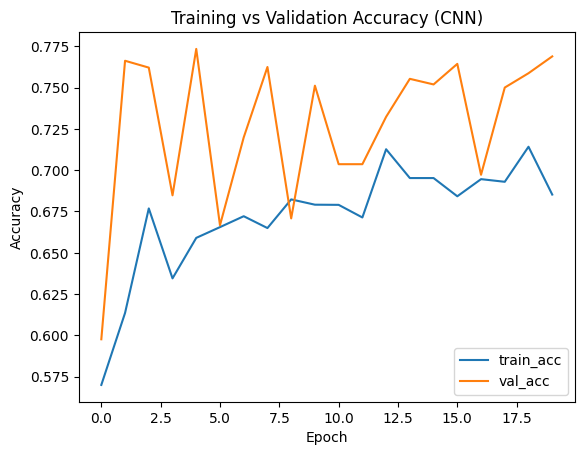

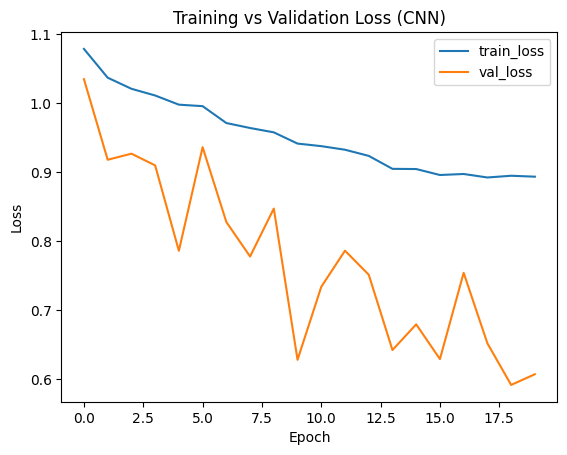

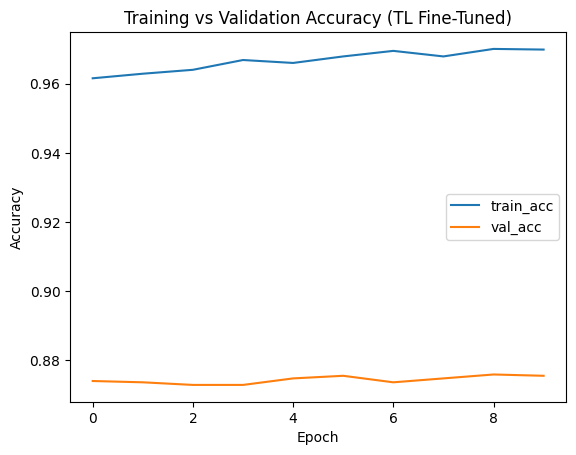

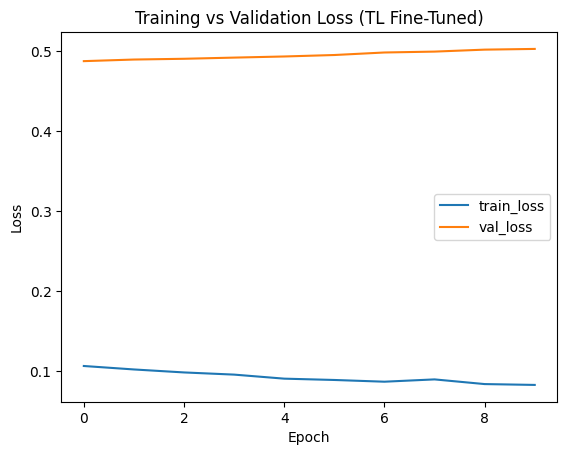

In [ ]:
# Po trenowaniu podstawowego CNN (history_cnn) dodaj wykresy:
# 1) Accuracy
plt.figure()
plt.plot(history_cnn.history['accuracy'],    label='train_acc')
plt.plot(history_cnn.history['val_accuracy'], label='val_acc')
plt.title('Training vs Validation Accuracy (CNN)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('fig_cnn_accuracy.png', bbox_inches='tight')

# 2) Loss
plt.figure()
plt.plot(history_cnn.history['loss'],    label='train_loss')
plt.plot(history_cnn.history['val_loss'], label='val_loss')
plt.title('Training vs Validation Loss (CNN)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('fig_cnn_loss.png', bbox_inches='tight')

# Po fine-tuningu TL (history_ft) dodaj analogiczne wykresy:
plt.figure()
plt.plot(history_ft.history['accuracy'],    label='train_acc')
plt.plot(history_ft.history['val_accuracy'], label='val_acc')
plt.title('Training vs Validation Accuracy (TL Fine-Tuned)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('fig_tlft_accuracy.png', bbox_inches='tight')

plt.figure()
plt.plot(history_ft.history['loss'],    label='train_loss')
plt.plot(history_ft.history['val_loss'], label='val_loss')
plt.title('Training vs Validation Loss (TL Fine-Tuned)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('fig_tlft_loss.png', bbox_inches='tight')

# Po wyznaczeniu predykcji ensemble na zbiorze walidacyjnym:
val_preds_ens = ensemble_preds  # z wcześniejszego kroku
y_true = np.argmax(y_val, axis=1)

# 4) Occlusion Saliency Map (poniżej przykład dla pierwszego obrazu walidacyjnego)
def occlusion_saliency(model, image, label_idx, patch_size=28):
    h, w, _ = image.shape
    baseline_prob = model.predict(image[np.newaxis,...])[0, label_idx]
    saliency = np.zeros((h, w))
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            occl = image.copy()
            occl[i:i+patch_size, j:j+patch_size, :] = 0
            p = model.predict(occl[np.newaxis,...])[0, label_idx]
            saliency[i:i+patch_size, j:j+patch_size] = baseline_prob - p
    return saliency

sample_img   = X_val[0]
sample_label = np.argmax(y_val[0])
sal_map = occlusion_saliency(cnn, sample_img, sample_label, patch_size=28)

plt.figure(figsize=(6,6))
plt.imshow(sample_img.squeeze(), cmap='gray')
plt.imshow(sal_map,        cmap='jet', alpha=0.5)
plt.title(f'Occlusion Saliency Map (label={sample_label})')
plt.axis('off')
plt.savefig('fig_saliency_map.png', bbox_inches='tight')